### Objective
The prediction of the clinical dementia rating (CDR) for Alzheimer's disease (AD) by patients' clinical assessments and MRI data.  

**Data source:** OASIS-3 open access series of imaging data. In the data set, MRI imaging data has been processed/analyzed by Freesurfer including cortical reconstruction and volumetric segmentation of MRI images. 

### Methodology

**Features:**  
- **MMSE** :The Mini-Mental State Examination (MMSE) is a 30-point questionnaire that is used to measure cognitive impairment.It is commonly used in medicine and allied health to screen for dementia.  Advantages to the MMSE include requiring no specialized equipment or training for administration. It is simper evaluation (usually  takes between 5 and 10 minutes) than neuropsychological assisted CDR evaluations. score Ranges from 0 (worst)to 30(best).The MMSE’s purpose has been not, on its own, to provide a diagnosis for any particular nosological entity.
  
- **M/F** : patient's gender    
- **Weight** : patient's weight  
  
- **Intracranial volume** : MRI data has been processed and the intracranial vol is calculated by Freesurfer as the volume inside of the cranium. 
    
- **Subcortical gray volume** : Volumetric reduction in hippocampus and parahippocampal are found in the AD patients. Hippocampus is located in the subcortical gray region. Study have shown the normalization of regional volumes (subcortical gray vol in this case) by intracranial volume (ICV) is important to estimate the extent of disease-driven atrophy.  SC_ratio is used in the project as a way to normalize Subcortical vol (calculated as Subcortical vol/ICV)
    
- **APOE genotype** : The most common gene associated with late-onset Alzheimer's disease is a risk gene called apolipoprotein E (APOE). Patients with APOE e4 are associated with higher risk of AD. 

- **Functional Assessment** : Consists of 10 questions to assess if the patient is capable of performing the activities independently e.g. remember dates, pay bills

| Assessment Name | Question |
|---------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| BILLS | In the past four weeks, did the subject have any difficulty or need help with writing checks, paying bills, or balancing a checkbook. |
| TAXES | In the past four weeks, did the subject have any difficulty or need help with assembling tax records, business affairs, or other papers. |
| SHOPPING | In the past four weeks, did the subject have any difficulty or need help with shopping alone for clothes, household necessities, or groceries. |
| GAMES | In the past four weeks, did the subject have any difficulty or need help with playing a game of skill such as bridge or chess, working on a hobby. |
| STOVE | In the past four weeks, did the subject have any difficulty or need help with heating water, making a cup of coffee, turning off the stove. |
| MEALPREP | In the past four weeks, did the subject have any difficulty or need help with preparing a balanced meal. |
| EVENTS | In the past four weeks, did the subject have any difficulty or need help with keeping track of current events. |
| PAYATTN | In the past four weeks, did the subject have any difficulty or need help with paying attention to and understanding a TV program, book or magazine. |
| REMDATES | In the past four weeks, did the subject have any difficulty or need help with remembering appointments, family occasions, holidays, medications. |
| TRAVEL | In the past four weeks, did the subject have any difficulty or need help with traveling out of the neighborhood, driving, or arranging to take public transportation. |

**Target:**  
  
The clinical dementia rating (CDR) was used as the target. It is a numeric scale quantifying the severity of symptoms of dementia. The patient’s cognitive and functional performances were assessed in six areas: memory, orientation, judgment & problem solving, community affairs, home & hobbies, and personal care.   
CDR has demonstrated high reliability for diagnosis of the severity of cognitive problems in AD, but the interview process requires training and can be time consuming (45-60 mins).

CDR scale  
  
0 = Normal  
0.5 = Very Mild Dementia  
1 = Mild Dementia  
2 = Moderate Dementia  
3 = Severe Dementia  


### EDA

![title](images/CDR_0917_1.jpg)

Above is the distribution of the target (CDR), which shows an imbalanced distribution of normal patients vs. patients with various stage of dementia. Due to the imbalanced distribution of the classes and the disability to correctly differentiate 0.5/1.0 class and 2.0/3.0 class in my earlier model, I create a simpler version of the CDR classification with 3 classes:  

0 = Normal  
1.0 = Very Mild/Mild Dementia  
2.0 = Moderate/Severe Dementia  

![title](images/CDR_0917_2.jpg)

### Initial Result

**Features selected**: MMSE, gender, intracranialvol, SubCortical, and APOE

Since the study is focused on the diagnosis of AD, it makes sense that we'd want a good balance of precision/recall score. Thus, a F1-score will be a good measurement of the model.  
  
With the above listed features fit with logistic regression model, here is the classification report with a weighted F1-score of 0.824. However, the recall score for 1.0 class doesn't look good and I'd like to further exam to see if I can improve it with other model. 

![image.png](images/Logistic_Regression_0917.jpg)

Modeling my data set with gradient boosting method, I am able to improve the **weighted F1-score to 0.860**. Please see below the classification report for each class.
![image.png](images/Gradient_Boosting_0917.jpg)



## Final Result

**Feature selected**: MMSE, gender, intracranialvol, SubCortical, APOE , and functional assessment

By adding the functional assessment data, I've trained the data with XGboost and got **weighted F1-score 0.911**
![image.png](images/Gradient_Boosting_0917_2.jpg)
  
    
      
        
          







***

## Reference Code

In [37]:
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rc('font', size=20)

%matplotlib inline

# modelling imports
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC,LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import warnings
warnings.filterwarnings('ignore')

Loading datafram and data processing

In [181]:
#load data from pkl file that I've done some preprocessing to combine three table
master_patient=pd.read_pickle("./patient_with_clinical_MRI.pkl")

#create dataframe that only include relevant info
df_model=master_patient[['subject','mmse','mf','hand','height','weight','intracranialvol','subcortgrayvol','cdr','ageatentry','apoe']]

#replace str opject to 0,1
df_model.mf.replace('M',1,inplace=True)
df_model.mf.replace('F',0,inplace=True)
df_model.hand.replace('R',1,inplace=True)
df_model.hand.replace('L',0,inplace=True)
df_model.hand.replace('A',2,inplace=True)
df_model['cdr']=df_model['cdr'].astype(str)

#fill null value for APOE genotype with 0
df_model.apoe.fillna(0, inplace=True)

df_model.dropna(inplace=True)


Normalize SubCortical volume by dividing SubCortical volume by Intracranial volume

In [182]:
df_model['SC_ratio']=df_model['subcortgrayvol']/df_model['intracranialvol']

In [183]:
x=df_model[['mmse','mf','hand','height','weight','intracranialvol','SC_ratio','apoe']]
y=df_model['cdr']

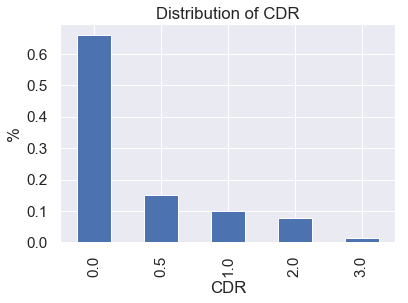

In [67]:
sns.set(font_scale=1.4)
plt.figure(figsize=(6,4))
y_count=y.value_counts(normalize=True)
y_count.plot(kind='bar')
plt.xlabel('CDR')
plt.ylabel('%')
plt.title('Distribution of CDR')
sns.despine(bottom=True, left=True)
plt.savefig('Distribution of CDR_0917_1.jpg')

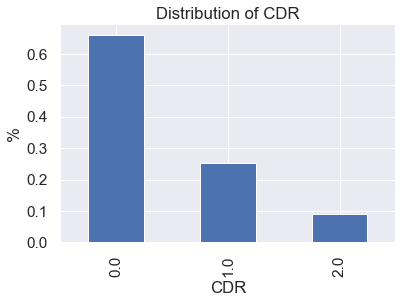

In [68]:
# create a simpler version of the CDR classification with 3 classes
y.replace('3.0','2.0', inplace = True)
y.replace('0.5','1.0', inplace = True)

sns.set(font_scale=1.4)
plt.figure(figsize=(6,4))

y_count=y.value_counts(normalize=True)
y_count.plot(kind='bar')
plt.xlabel('CDR')
plt.ylabel('%')
plt.title('Distribution of CDR')
sns.despine(bottom=True, left=True)
plt.savefig('Distribution of CDR_0917_2.jpg')

### Train the model with MMSE, weight, gender, intracranialvol, SubCortical, and APOE

In [72]:
x=df_model[['mmse','mf','weight','intracranialvol','SC_ratio','apoe']]
y=df_model['cdr']

#build train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, random_state=4444)

std_scale = StandardScaler()

x_train_scaled = std_scale.fit_transform(x_train)
x_test_scaled = std_scale.transform(x_test)

In [73]:
# logistic Regression Score
lr = LogisticRegression(C=1000)
lr.fit(x_train_scaled, y_train)
lr_pred=lr.predict(x_test_scaled)


#SVM
svm = SVC(kernel='linear')
svm.fit(x_train_scaled, y_train)
svm_pred=svm.predict(x_test_scaled)


#Random Forest
rf=RandomForestClassifier()
rf.fit(x_train_scaled, y_train)
rf_pred=rf.predict(x_test_scaled)

classifier={'Logistic Regression':lr_pred,'SVM':svm_pred,'Random Forest': rf_pred}
for key,value in classifier.items():
    print('\n',key)
    print(f'Accuracy Score:{accuracy_score(y_test,value):.3f}')
    print(f'Precision Score:{precision_score(y_test,value, average="weighted"):.3f}')
    print(f'Recall Score:{recall_score(y_test,value, average="weighted"):.3f}')
    print(f'F1 Score:{f1_score(y_test,value, average="weighted"):.3f}')


 Logistic Regression
Accuracy Score:0.840
Precision Score:0.836
Recall Score:0.840
F1 Score:0.823

 SVM
Accuracy Score:0.833
Precision Score:0.823
Recall Score:0.833
F1 Score:0.823

 Random Forest
Accuracy Score:0.819
Precision Score:0.819
Recall Score:0.819
F1 Score:0.819


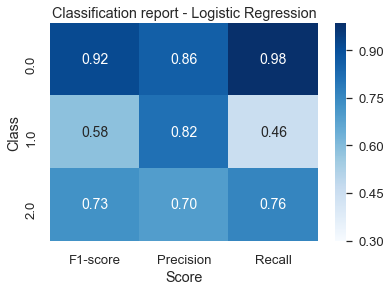

In [74]:
report = classification_report(y_test, lr_pred, output_dict=True)
report_df =pd.DataFrame(report).transpose()
plt.figure(figsize=(6,4))
sns.set(font_scale=1.2)

sns.heatmap(report_df.iloc[0:3,0:3], annot=True,cmap="Blues",fmt='.2f',annot_kws={"size":14},vmin=0.3,
           xticklabels=['F1-score', 'Precision', 'Recall'],
           yticklabels=['0.0', '1.0', '2.0'])
plt.xlabel('Score')
plt.ylabel('Class')
plt.title('Classification report - Logistic Regression')
plt.savefig('Classification report-Logistic Regression_0917.jpg')

In [75]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4444)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=4444)


gbm = xgb.XGBClassifier( 
                        n_estimators=3000,
                        max_depth=5,
                        objective='multi:softmax', #new objective
                        learning_rate=.1, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='mlogloss', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=30,
                    verbose=False
                   )

gbm_pred=gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)

print('Gradient Boosting')
print(f'Accuracy Score:{accuracy_score(y_test,gbm_pred):.3f}')
print(f'Precision Score:{precision_score(y_test,gbm_pred, average="weighted"):.3f}')
print(f'Recall Score:{recall_score(y_test,gbm_pred, average="weighted"):.3f}')
print(f'F1 Score:{f1_score(y_test,gbm_pred, average="weighted"):.3f}')

Gradient Boosting
Accuracy Score:0.861
Precision Score:0.868
Recall Score:0.861
F1 Score:0.860


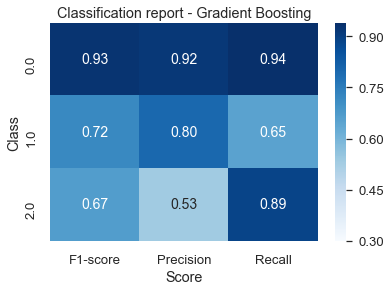

In [76]:
report = classification_report(y_test, gbm_pred, output_dict=True)
report_df =pd.DataFrame(report).transpose()
report_df.iloc[0:3,0:3]

plt.figure(figsize=(6,4))
sns.set(font_scale=1.2)

sns.heatmap(report_df.iloc[0:3,0:3], annot=True,cmap="Blues",fmt='.2f',annot_kws={"size":14},vmin=0.3,
           xticklabels=['F1-score', 'Precision', 'Recall'],
           yticklabels=['0.0', '1.0', '2.0'])
plt.xlabel('Score')
plt.ylabel('Class')
plt.title('Classification report - Gradient Boosting')
plt.savefig('Classification report-Gradient Boosting_0917.jpg')

### Add Functional Assessment Data

In [175]:
#functional data is sourced from another table
df2= pd.read_csv('FAQ.csv')
df2['day'] = df2['UDS_B7FAQDATA ID'].apply(lambda x: x.split('_')[2])
df2['day'] = df2['day'].apply(lambda x: x.replace('d','')).astype(int)

#each subject contains multiple entries and I've filled the null value with the majority vote for the question from the particular patient
df2 = df2.groupby(['Subject'], as_index= False).apply(lambda x: x.fillna(x.mode()))
df2 = df2.groupby(['Subject'], as_index= False).last()

In [176]:
df2=df2.fillna(0)
df2=df2.drop(['UDS_B7FAQDATA ID','Date','Age'],axis=1)
df2.rename(columns={'Subject':'subject'}, inplace=True)

In [209]:
#merge the original dataframe with functional assessment Data
master=pd.merge(df_model,df2,on='subject',how='left')

In [210]:
master.apoe.fillna(0, inplace=True)
master.BILLS.fillna(9, inplace=True)
master.TAXES.fillna(9, inplace=True)
master.SHOPPING.fillna(9, inplace=True)
master.GAMES.fillna(9, inplace=True)
master.STOVE.fillna(9, inplace=True)
master.MEALPREP.fillna(9, inplace=True)
master.EVENTS.fillna(9, inplace=True)
master.PAYATTN.fillna(9, inplace=True)
master.REMDATES.fillna(9, inplace=True)
master.TRAVEL.fillna(9, inplace=True)

In [211]:
x=master[['mmse','mf','weight','intracranialvol','SC_ratio','apoe','BILLS', 'TAXES','SHOPPING','GAMES','STOVE'
                        ,'MEALPREP','EVENTS','PAYATTN','REMDATES','TRAVEL']]
y=master['cdr']
y.replace('3.0','2.0', inplace = True)
y.replace('0.5','1.0', inplace = True)

In [212]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=387)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=44)


gbm = xgb.XGBClassifier( 
                        n_estimators=3000,
                        max_depth=5,
                        objective='multi:softmax', #new objective
                        learning_rate=.1, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='mlogloss', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=30,
                    verbose=False
                   )

gbm_pred=gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)

print('Gradient Boosting')
print(f'Accuracy Score:{accuracy_score(y_test,gbm_pred):.3f}')
print(f'Precision Score:{precision_score(y_test,gbm_pred, average="weighted"):.3f}')
print(f'Recall Score:{recall_score(y_test,gbm_pred, average="weighted"):.3f}')
print(f'F1 Score:{f1_score(y_test,gbm_pred, average="weighted"):.3f}')

Gradient Boosting
Accuracy Score:0.914
Precision Score:0.914
Recall Score:0.914
F1 Score:0.911


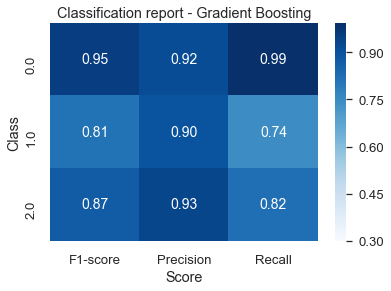

In [213]:
report = classification_report(y_test, gbm_pred, output_dict=True)
report_df =pd.DataFrame(report).transpose()
report_df.iloc[0:3,0:3]

plt.figure(figsize=(6,4))
sns.set(font_scale=1.2)

sns.heatmap(report_df.iloc[0:3,0:3], annot=True,cmap="Blues",fmt='.2f',annot_kws={"size":14},vmin=0.3,
           xticklabels=['F1-score', 'Precision', 'Recall'],
           yticklabels=['0.0', '1.0', '2.0'])
plt.xlabel('Score')
plt.ylabel('Class')
plt.title('Classification report - Gradient Boosting')
plt.savefig('Classification report-Gradient Boosting_0917_2.jpg')